In [ ]:
# This file is part of LOVE-integration-tools.
#
# Copyright (c) 2023 Inria Chile.
#
# Developed by Inria Chile.
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or at
# your option any later version.
#
# This program is distributed in the hope that it will be useful,but
# WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
# or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License
# for more details.
#
# You should have received a copy of the GNU General Public License along with
# this program. If not, see <http://www.gnu.org/licenses/>.

# LOVE stress test

The following code is used to stress test a particular instance of the LOVE stack. This is done by generating several client connections (`N_CLIENTS`) for a specific LOVE-manager deploy (`MANAGER_LOCATION`). These clients will subscribe to all the telemetries and events of the specified CSCs (`LOVE_PRODUCER_SET`), will start listening to messages and for each of them will calculate timestamp difference to calculate the latency of the message. This latency is understood as the time between a message is received from SAL and the time it is received by the client.

This test is supposed to run alongside a LOVE deployment with the following components:

- LOVE-manager
- LOVE-producer(s) for each of the CSCs in `LOVE_PRODUCER_SET`

Also credentials for access are required in order to connect to a specific LOVE-manager deploy (`MANAGER_USER` and `MANAGER_PASSWORD`)

In [6]:
MANAGER_LOCATION = 'dev.love.inria.cl' # Host of the LOVE-manager
MANAGER_USER = 'test' # User to connect to the LOVE-manager
MANAGER_PASSWORD = 'test' # User password to connect to the LOVE-manager
N_CLIENTS = 20 # Number of clients to simulate
LOVE_PRODUCER_SET = {'ATDome:0', 'ATAOS:0', 'ATCamera:0', 'ATHexapod:0', 'ATMCS:0', 'ATPneumatics:0', 'ATSpectrograph:0',
                     'MTDome:0', 'MTMount:0', 'MTM2:0', 'MTM1M3:0', 'MTRotator:0', 'MTM1M3:0', 'MTHexapod:1', 'MTHexapod:2',
                     'WeatherStation:1' } # Set of Producers to use as emitters
#LOVE_PRODUCER_SET = {'ATDome:0', 'ATAOS:0'} # Set of Producers to use as emitters

In [7]:
from lsst.ts import salobj
domain = salobj.Domain()
event_streams = { producer: salobj.SalInfo(domain, producer.split(':')[0]).__getattribute__(f"event_names") for producer in LOVE_PRODUCER_SET }
telemetry_streams = { producer: salobj.SalInfo(domain, producer.split(':')[0]).__getattribute__(f"telemetry_names") for producer in LOVE_PRODUCER_SET }
print(event_streams, telemetry_streams)

{'ATAOS:0': ('atspectrographCorrectionCompleted', 'atspectrographCorrectionStarted', 'authList', 'configurationApplied', 'configurationsAvailable', 'correctionEnabled', 'correctionOffsets', 'detailedState', 'errorCode', 'focusCorrectionCompleted', 'focusCorrectionStarted', 'focusOffsetSummary', 'heartbeat', 'hexapodCorrectionCompleted', 'hexapodCorrectionStarted', 'logLevel', 'logMessage', 'm1CorrectionCompleted', 'm1CorrectionStarted', 'm2CorrectionCompleted', 'm2CorrectionStarted', 'pointingOffsetSummary', 'simulationMode', 'softwareVersions', 'summaryState'), 'ATDome:0': ('allAxesInPosition', 'authList', 'azimuthCommandedState', 'azimuthInPosition', 'azimuthState', 'configurationApplied', 'configurationsAvailable', 'doorEncoderExtremes', 'dropoutDoorCommandedState', 'dropoutDoorState', 'emergencyStop', 'errorCode', 'heartbeat', 'lastAzimuthGoTo', 'logLevel', 'logMessage', 'mainDoorCommandedState', 'mainDoorState', 'moveCode', 'scbLink', 'settingsAppliedDomeController', 'settingsAppl

In [8]:
import aiohttp
import json
import asyncio
import requests
from astropy.time import Time

class clientInstance:
    
    def __init__(self):
        self.latencies = []
        self.rcv_latencies = []
        self.websocket_url = ''
        self.received_messages = 0
        self.msg_traces = []
    
    def request_token(self):
        url = f'http://{MANAGER_LOCATION}/manager/api/get-token/'
        data = {
            'username': MANAGER_USER,
            'password': MANAGER_PASSWORD,
        }
        resp = requests.post(url, data = data)
        token = resp.json()['token']
        self.websocket_url = f'ws://{MANAGER_LOCATION}/manager/ws/subscription?token={token}'
    
    async def handle_message_reception(self):
        """Handles the reception of messages"""
        if self.websocket:
            async for message in self.websocket:
                if message.type == aiohttp.WSMsgType.TEXT:
                    msg = json.loads(message.data)
                    if 'category' not in msg or ("option" in msg and msg["option"] == "subscribe"):
                        continue
                    self.received_messages = self.received_messages + 1
                    #print(msg)
                    tracing = msg["tracing"]
                    tracing['client_rcv'] = Time.now().tai.datetime.timestamp()
                    self.msg_traces.append(tracing)
    
    async def subscribe_to(self, csc, salindex, stream, topic_type):
        subscribe_msg = {
            'option': 'subscribe',
            'category': topic_type,
            'csc': csc,
            'salindex': salindex,
            'stream': stream
        }
        await self.websocket.send_str(json.dumps(subscribe_msg))
    
    async def start_ws_client(self):
        async with aiohttp.ClientSession() as session:
            self.websocket = await session.ws_connect(self.websocket_url)
            for producer in LOVE_PRODUCER_SET:
                csc_tokens = producer.split(':')
                for stream in event_streams[producer]:
                    await self.subscribe_to(csc_tokens[0], csc_tokens[1], stream, 'event')
                for stream in telemetry_streams[producer]:
                    await self.subscribe_to(csc_tokens[0], csc_tokens[1], stream, 'telemetry')
                
            await self.handle_message_reception()


In [9]:
# Create clients and listen to ws messages
loop = asyncio.get_event_loop()
clients = [clientInstance() for i in range(N_CLIENTS)]
[c.request_token() for c in clients]
client_tasks = [loop.create_task(c.start_ws_client()) for c in clients]

In [15]:
clients[0].received_messages

122

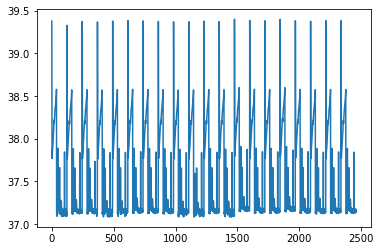

In [16]:
import matplotlib.pyplot as plt
traces = [trace for client in clients for trace in client.msg_traces]
producer_snd_vals = sorted([trace['producer_snd'] for trace in traces])
manager_snd_client_vals = sorted([trace['manager_snd_to_client'] for trace in traces])
#latency_vals = sorted([trace['client_rcv'] - trace['producer_snd'] for trace in traces])
latency_vals = [trace['client_rcv'] - trace['producer_snd'] for trace in traces]
#plt.plot(producer_snd_vals)
#plt.plot(manager_snd_client_vals)
plt.plot(latency_vals)

In [17]:
from statistics import mean
average_latency = mean(latency_vals)
print(f"Average Latency: {average_latency} ms")

Average Latency: 37.51051235034214 ms


In [ ]:
import psutil
print(psutil.cpu_percent())
print(psutil.virtual_memory()._asdict())